In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")
import random
import pandas as pd
import numpy as np

import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
device

'cuda:0'

# Получаем данные

In [3]:
BATCH_SIZE = 32
transoforms1 = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

transoforms2 = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

transoforms3 = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((29, 29)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', 'balanced',train=True,  transform=transoforms1, download=True)
test_dataset = tv.datasets.EMNIST('.', 'balanced',train=False,  transform=transoforms1, download=True)

#!!!ОГРАНИЧЕНИЕ КОЛИЧЕСТВА КЛАССОВ,
#при исходном датасете обучение за приемлемое время проходит только resnet18,
#остальные - на имеющемся оборудовании на одну эпоху до 3х часов нужно, colab - ещё медленнее (gpu там не подключается)
#поэтому с полным датасетом сделал одну эпоху, а с урезанным - 3

#n_classes = 3
#train_dataset.data = train_dataset.data[train_dataset.targets < n_classes]
#train_dataset.targets = train_dataset.targets[train_dataset.targets < n_classes]
#test_dataset.data = train_dataset.data[train_dataset.targets < n_classes]
#test_dataset.targets = train_dataset.targets[train_dataset.targets < n_classes]

#train_dataset.train_data.to(device)
#train_dataset.train_labels.to(device)
#test_dataset.train_data.to(device)
#test_dataset.train_labels.to(device)

train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [4]:
train_dataset.data.shape

torch.Size([112800, 28, 28])

In [5]:
test_dataset.data.shape

torch.Size([18800, 28, 28])

In [6]:
#количество классов и их распределение
out_n = len(set(train_dataset.targets.numpy()))
print(out_n)
train_dataset.targets.unique(return_counts=True)

47


(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 tensor([2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400,
         2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400,
         2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400,
         2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400]))

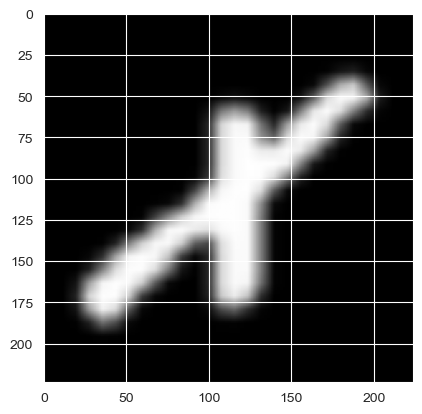

In [7]:
plt.imshow(train_dataset[100][0].numpy().T, cmap='gray');

# Тестируем архитектуры

In [8]:
#класс тренировки и тестирования одной модели, сохраняет результаты по каждой эпохе в соответствующие массивы
class TTresults:
    
    def __init__(self,trainer,loss,cuda=False,show_train=True,show_iter_n = 50):
        
        self.loss = loss
        self.trainer = trainer
        
        self.cuda = cuda
        self.show_train = show_train
        self.show_iter_n = show_iter_n
        
        self.e_train_times=[]
        self.e_test_times=[]
        self.e_train_loss =[]
        self.e_train_acc =[]
        self.e_test_loss =[]
        self.e_test_acc =[]
    
    def train(self,net, train_iter, test_iter,num_epochs):
        if self.cuda:
            net.to(device)
        net.train()
        for epoch in range(num_epochs):
            
            train_l_sum, train_acc_sum, n, iters, start = 0.0, 0.0, 0, 0, time.time()
            for i, (X, y) in enumerate(train_iter):
                if self.cuda:
                    X, y = X.to(device), y.to(device)
                self.trainer.zero_grad()
                y_hat = net(X)
                l = self.loss(y_hat, y)
                l.backward()
                self.trainer.step()
                train_l_sum += l.item()
                train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
                n += y.shape[0]
                iters += 1
                #torch.cuda.empty_cache()
                
                if self.show_iter_n > 0 and i % self.show_iter_n==0:
                    print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
                
                
            self.e_train_times.append(time.time() -  start)
            self.e_train_loss.append(train_l_sum / iters)
            self.e_train_acc.append(train_acc_sum / n)
                
            test_acc = self.evaluate_accuracy(test_iter, net)
            if self.show_train:
                self.show_epoch(epoch)
            
        net.to('cpu')
                
    def show_epoch(self,epoch):
        print("ep: {}, tt_time: {:.3f}, train_loss: {}, train_acc: {}, test_loss: {}, test_acc: {}".format(
            epoch, 
            self.e_train_times[-1]+self.e_test_times[-1], 
            round(self.e_train_loss[-1],5), 
            round(self.e_train_acc[-1],5),
            round(self.e_test_loss[-1],5), 
            round(self.e_test_acc[-1],5)))
    
    def evaluate_accuracy(self,data_iter,net):
        l_sum, acc_sum, n, iters, start= 0, 0, 0, 0, time.time()
        
        net.eval()
        for X, y in data_iter:
            if self.cuda:
                X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = self.loss(y_hat, y)
            l_sum += l.item()
            acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            iters += 1
            #torch.cuda.empty_cache()
            
        self.e_test_times.append(time.time() -  start)
        self.e_test_loss.append(l_sum / iters)
        self.e_test_acc.append(acc_sum / n)

    def get_last_results(self):
        r = {}
        r['train_time'] =  self.e_train_times
        r['test_time']  =  self.e_test_times
        r['train_loss']  =  self.e_train_loss
        r['train_acc']  =  self.e_train_acc
        r['test_loss']  =  self.e_test_loss
        r['test_acc']  =  self.e_test_acc
        r = pd.DataFrame(r)
        r['ep'] = r.index
        return r
    
    
# запускает каждую модель из списка кортежей (имя,модель), берёт результаты последней эпохи, сохраняет их в df
# берём одинаковые loss и оптимизатор для всех моделей
class ComparisonTable:
    def __init__(self,models: list[tuple], loss_f, trainer_f, epoch_n, cuda=False):
        
        if len(set([id(x[1]) for x in models])) != len(models):
            raise "Модели задублированы"
        self.models = models
        self.cuda = cuda
        self.loss_f = loss_f
        self.trainer_f = trainer_f
        self.epoch_n = epoch_n
        self.result = pd.DataFrame()
        
    def get_comparison_table(self,train_iter,test_iter)->pd.DataFrame:
        result = pd.DataFrame()
        
        for name,model,transforms in self.models:
            print('-'*20)
            print(f'{name} model was started')
            
            train_iter.dataset.transform = transforms
            test_iter.dataset.transform = transforms
            
            r = self.train_one(model,train_iter,test_iter)
            r['model_name'] = name
            if result.shape[0]==0:
                result = r.copy()
            else:
                result = result.append(r,ignore_index=True)
                
       
        return result
    
    def train_one(self,model,train_iter,test_iter):
        
        loss = self.loss_f()
        trainer =  self.trainer_f(model.parameters(), lr=0.001)
        num_epochs = self.epoch_n
        
        tt = TTresults(trainer,loss,cuda=self.cuda,show_train=True)
        tt.train(model, train_iter, test_iter, num_epochs)
        
        return tt.get_last_results()

In [9]:
resnet18_model = tv.models.resnet18(pretrained=False)
resnet18_model.fc = nn.Linear(in_features=512, out_features=out_n)
#resnet18_model
#summary(resnet18_model, input_size=(3, 224, 224), device='cpu')

In [10]:
vgg16_model = tv.models.vgg16(pretrained=False)
vgg16_model.classifier[6] = nn.Linear(in_features=4096, out_features=out_n)
#vgg16_model
#summary(vgg16_model, input_size=(3, 224, 224), device='cpu')

In [11]:
Inception_v3 = tv.models.inception_v3(pretrained=False)
Inception_v3.fc = nn.Linear(in_features=2048, out_features=out_n)
Inception_v3.aux_logits=False
#Inception_v3
#summary(Inception_v3, input_size=(3, 299, 299), device='cpu')

In [12]:
DenseNet_161 = tv.models.densenet161(pretrained=False)
DenseNet_161.classifier = nn.Linear(in_features=2208, out_features=out_n)
#DenseNet_161

In [13]:
models_list = [('resnet18',resnet18_model,transoforms1),
              ('vgg16',vgg16_model,transoforms1),
              ('Inception_v3',Inception_v3,transoforms2),
              ('DenseNet_161',DenseNet_161,transoforms3)]

### Результаты с урезанным до 3х классов набором данных и 3-мя эпохами

In [14]:
loss_f = torch.nn.CrossEntropyLoss
trainer_f = torch.optim.Adam
num_epochs = 3
ct  = ComparisonTable(models_list, loss_f, trainer_f, num_epochs,cuda=True)

In [15]:
c_table = ct.get_comparison_table(train, test)

--------------------
resnet18 model was started
Step 0. time since epoch: 0.433. Train acc: 0.344. Train Loss: 0.035
Step 50. time since epoch: 4.640. Train acc: 0.932. Train Loss: 0.006
Step 100. time since epoch: 8.837. Train acc: 0.957. Train Loss: 0.004
Step 150. time since epoch: 13.141. Train acc: 0.965. Train Loss: 0.003
Step 200. time since epoch: 17.520. Train acc: 0.972. Train Loss: 0.003
ep: 0, tt_time: 29.032, train_loss: 0.07975, train_acc: 0.97444, test_loss: 0.01712, test_acc: 0.99542
Step 0. time since epoch: 0.118. Train acc: 1.000. Train Loss: 0.000
Step 50. time since epoch: 4.229. Train acc: 0.547. Train Loss: 0.066
Step 100. time since epoch: 8.361. Train acc: 0.662. Train Loss: 0.040
Step 150. time since epoch: 12.487. Train acc: 0.753. Train Loss: 0.029
Step 200. time since epoch: 16.642. Train acc: 0.810. Train Loss: 0.022
ep: 1, tt_time: 28.111, train_loss: 0.63843, train_acc: 0.82861, test_loss: 0.06535, test_acc: 0.98569
Step 0. time since epoch: 0.083. Train

In [16]:
c_table

,train_time,test_time,train_loss,train_acc,test_loss,test_acc,ep,model_name
0,19.584000,9.447891,0.079750,0.974444,0.017125,0.995417,0,resnet18
1,18.642390,9.468899,0.638428,0.828611,0.065347,0.985694,1,resnet18
2,18.666186,9.555244,0.047792,0.986806,0.037801,0.992222,2,resnet18
3,86.805043,113.440809,0.532757,0.925139,0.042775,0.992917,0,vgg16
4,1749.845458,117.230938,0.030200,0.992361,0.050562,0.992361,1,vgg16
5,1775.324010,113.528083,0.042537,0.990278,0.032887,0.990556,2,vgg16
6,436.217650,199.616982,0.073717,0.976111,0.007867,0.997500,0,Inception_v3
7,422.477085,234.982927,1.790570,0.772639,0.124383,0.958750,1,Inception_v3
8,420.773301,237.241796,0.073193,0.977500,0.036043,0.992778,2,Inception_v3
9,66.975313,41.834374,0.055111,0.982222,0.009345,0.996806,0,DenseNet_161


In [ ]:
c_table.to_csv(r'result1.csv',index=False)

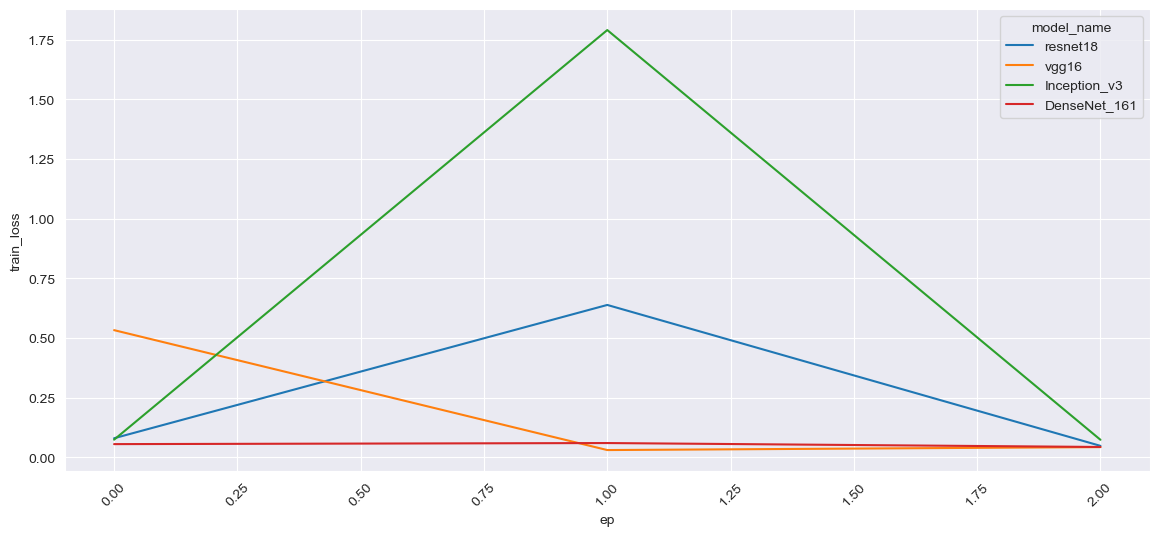

In [23]:
#train_loss
plt.figure(figsize=(14,6))
plt.xticks(rotation=45)
_ =sns.lineplot(data=c_table, x='ep', y='train_loss', hue='model_name')

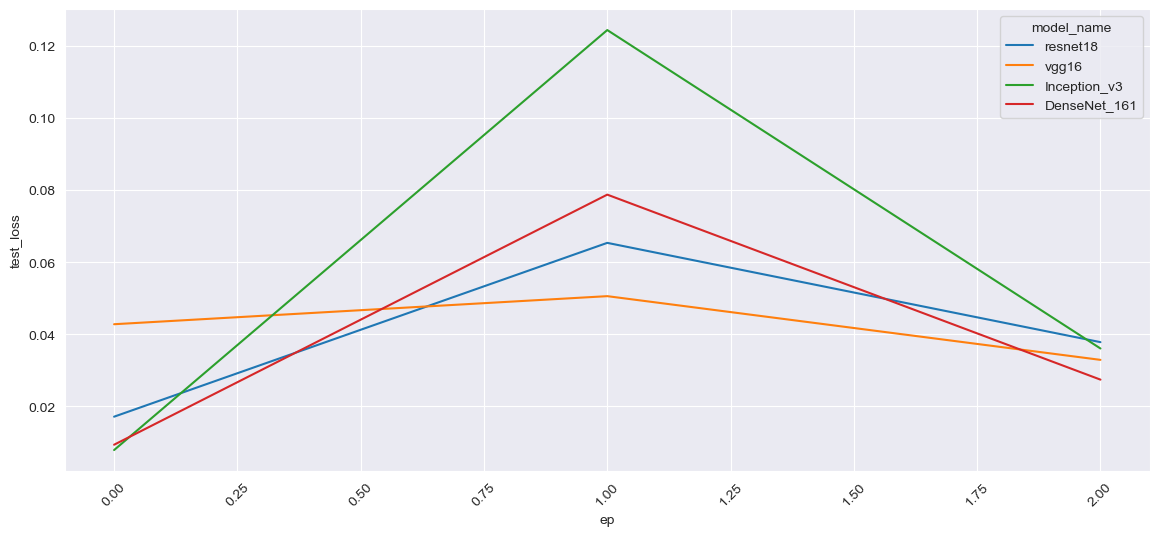

In [25]:
#test_loss
plt.figure(figsize=(14,6))
plt.xticks(rotation=45)
_ =sns.lineplot(data=c_table, x='ep', y='test_loss', hue='model_name')

### Результаты с полным набором данных и одной эпохой

In [14]:
loss_f = torch.nn.CrossEntropyLoss
trainer_f = torch.optim.Adam
num_epochs = 1
ct  = ComparisonTable(models_list, loss_f, trainer_f, num_epochs,cuda=True)

In [15]:
c_table = ct.get_comparison_table(train, test)

--------------------
resnet18 model was started
Step 0. time since epoch: 0.403. Train acc: 0.062. Train Loss: 0.122
Step 50. time since epoch: 4.658. Train acc: 0.254. Train Loss: 0.088
Step 100. time since epoch: 8.901. Train acc: 0.392. Train Loss: 0.069
Step 150. time since epoch: 13.138. Train acc: 0.481. Train Loss: 0.058
Step 200. time since epoch: 17.423. Train acc: 0.538. Train Loss: 0.050
Step 250. time since epoch: 21.767. Train acc: 0.578. Train Loss: 0.045
Step 300. time since epoch: 26.058. Train acc: 0.609. Train Loss: 0.042
Step 350. time since epoch: 30.320. Train acc: 0.632. Train Loss: 0.039
Step 400. time since epoch: 34.548. Train acc: 0.652. Train Loss: 0.037
Step 450. time since epoch: 38.780. Train acc: 0.668. Train Loss: 0.035
Step 500. time since epoch: 43.002. Train acc: 0.682. Train Loss: 0.033
Step 550. time since epoch: 47.246. Train acc: 0.693. Train Loss: 0.032
Step 600. time since epoch: 51.475. Train acc: 0.701. Train Loss: 0.031
Step 650. time since e

Step 1950. time since epoch: 757.634. Train acc: 0.021. Train Loss: 0.121
Step 2000. time since epoch: 776.764. Train acc: 0.020. Train Loss: 0.121
Step 2050. time since epoch: 797.277. Train acc: 0.020. Train Loss: 0.121
Step 2100. time since epoch: 818.099. Train acc: 0.020. Train Loss: 0.121
Step 2150. time since epoch: 837.375. Train acc: 0.020. Train Loss: 0.121
Step 2200. time since epoch: 856.756. Train acc: 0.021. Train Loss: 0.121
Step 2250. time since epoch: 876.027. Train acc: 0.021. Train Loss: 0.121
Step 2300. time since epoch: 895.350. Train acc: 0.021. Train Loss: 0.121
Step 2350. time since epoch: 914.708. Train acc: 0.021. Train Loss: 0.121
Step 2400. time since epoch: 934.047. Train acc: 0.020. Train Loss: 0.121
Step 2450. time since epoch: 953.348. Train acc: 0.020. Train Loss: 0.121
Step 2500. time since epoch: 972.765. Train acc: 0.020. Train Loss: 0.121
Step 2550. time since epoch: 992.046. Train acc: 0.020. Train Loss: 0.121
Step 2600. time since epoch: 1011.308.

Step 150. time since epoch: 112.885. Train acc: 0.534. Train Loss: 0.050
Step 200. time since epoch: 150.690. Train acc: 0.576. Train Loss: 0.045
Step 250. time since epoch: 191.966. Train acc: 0.605. Train Loss: 0.042
Step 300. time since epoch: 237.234. Train acc: 0.627. Train Loss: 0.039
Step 350. time since epoch: 277.178. Train acc: 0.640. Train Loss: 0.037
Step 400. time since epoch: 323.945. Train acc: 0.652. Train Loss: 0.036
Step 450. time since epoch: 364.218. Train acc: 0.665. Train Loss: 0.034
Step 500. time since epoch: 406.129. Train acc: 0.673. Train Loss: 0.033
Step 550. time since epoch: 448.103. Train acc: 0.682. Train Loss: 0.032
Step 600. time since epoch: 490.101. Train acc: 0.687. Train Loss: 0.032
Step 650. time since epoch: 532.042. Train acc: 0.692. Train Loss: 0.031
Step 700. time since epoch: 573.913. Train acc: 0.700. Train Loss: 0.030
Step 750. time since epoch: 616.425. Train acc: 0.705. Train Loss: 0.029
Step 800. time since epoch: 661.025. Train acc: 0.7

In [16]:
c_table

,train_time,test_time,train_loss,train_acc,test_loss,test_acc,ep,model_name
0,299.331169,25.175628,0.525395,0.822872,0.378286,0.871968,0,resnet18
1,1371.516857,295.194451,3.858422,0.020098,3.850195,0.021277,0,vgg16
2,8567.331379,660.316635,0.589782,0.806170,0.426088,0.857128,0,Inception_v3
3,2856.988263,106.796370,0.599397,0.801897,0.414335,0.858723,0,DenseNet_161


In [17]:
c_table.to_csv(r'result2.csv',index=False)